# Information content of a dynamic process

The goal of this paper is to aid in in analyzing complex dynamical processes by developing methods that can track these processes indepdendent of the underlying dynamics.

Here, we are looking at metastable behavior. Two processes we could look at are 

- Information dissipation time
- Asymptotic information

The process will involve out of equilibrium dynamics.

Initial starting points could be

- As a function of order paramter measure IDT vs AI
  - Use lattice at first
- Design toy model that displays specific dynamics

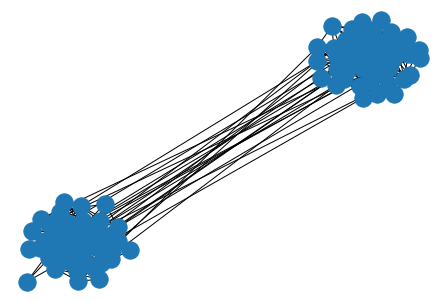

In [1]:
%load_ext autoreload
%autoreload 2
from plexsim.models import *
import sys; sys.path.insert(0, '../')
from Toolbox import signal as tsignal
from plotly import graph_objects as go
import networkx as nx, numpy as np
n = 50
# g = nx.grid_graph([n, n], periodic = True)
# g = nx.star_graph(n)
# g = nx.random_internet_as_graph(10)
p_1 = .2
p_2 = .2
p_3 = .3
# p_3 = 1 - p_2 - p_1

g1 = nx.erdos_renyi_graph(n, p_1)
g2 = nx.erdos_renyi_graph(n, p_2)

nx.set_node_attributes(g1, "a", "cluster")
nx.set_node_attributes(g2, "b", "cluster")

g = nx.union(g1, g2, rename = ("g1-", "g2-"))

attributes = nx.get_node_attributes(g, 'cluster')

tmp = dict()
for a, v in attributes.items():
    tmp[v] = tmp.get(v, []) + [a]

connect = set()
U = .01
for i in range(n):
    if np.random.rand() < p_3:
        u = np.random.choice(tmp['a'])
        v = np.random.choice(tmp['b'])
        g.add_edge(u, v, weight = U)

nx.draw(g)  

# assert 0

In [2]:
m = Ising(graph = g, t = 2., p_recomb = .5)
temps = np.linspace(0, 10, 20); #temps[-1] = 10000
out   = m.magnetize(temps, n = int(1e4))

Spawning threads
Magnetizing temperatures


0% [####################] 100% | ETA: 00:00:000% [##################  ] 100% | ETA: 00:00:010% [###############     ] 100% | ETA: 00:00:04
Total time elapsed: 00:00:16


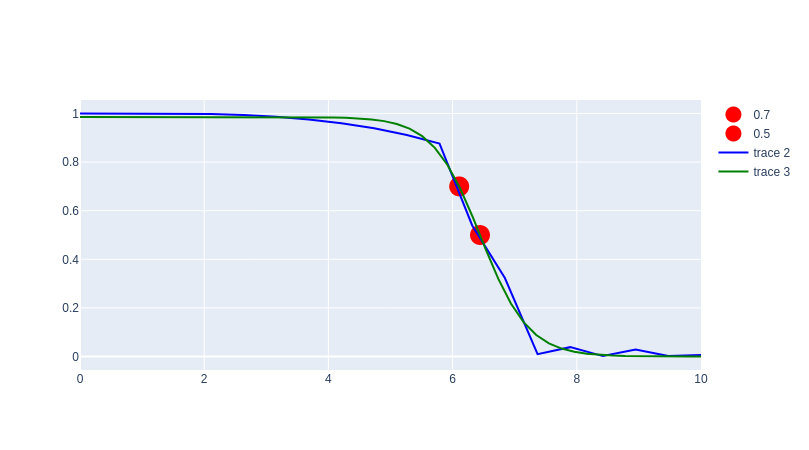

In [3]:
from scipy import optimize
def sig(x, a, b, c):
    return a / (1 + b * np.exp(c * x))
opts, cov = optimize.curve_fit(sig, xdata = temps, ydata = out[0],\
                      maxfev = 100_000)

thetas = [.7, .5]

data = []

simTemps = []
for theta in thetas:
    res = optimize.minimize(lambda x, c, theta: abs(sig(x, *c) - theta), x0 = temps.mean(), \
                        args = (opts, theta),\
                            method = 'TNC',\
                           )
    simTemps.append(res.x) 
    line = go.Scatter(x = res.x, y = sig(res.x, *opts), \
                      mode = 'markers',\
                     marker = dict(size = 20,\
                                   color = 'red'),\
                     name = f'{theta}')
    data.append(line) 
    
xr = np.linspace(0, 10)
data.append(go.Scatter(x = temps, y = out[0], line = dict(color = 'blue')))
data.append(go.Scatter(x = xr, y = sig(xr, *opts), line = dict(color = 'green')))
fig = go.Figure(data = data)
fig.show()


In [4]:
# get a feeling for tippings points of the system
m.t = simTemps[0]
print(m.t)
m.mcmc.p_recomb = 0
sim = m.simulate(int(1e4))

[6.10635404]


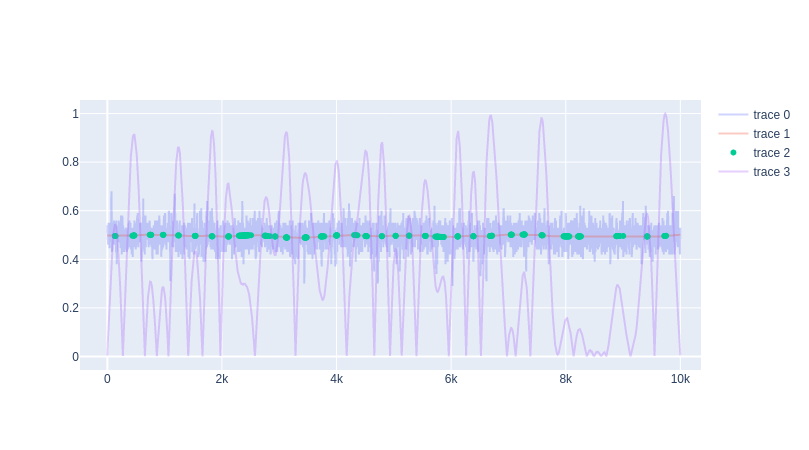

In [5]:
from scipy import ndimage, signal, fft
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.decomposition import PCA
mean = sim.mean(1)
xr = np.arange(mean.size)

from sklearn.neighbors import KNeighborsRegressor as KNR
# tmp      = knr.fit(X = xr[:, None], y = mean).predict(xr[:, None])
sigma = 150
filtered = ndimage.gaussian_filter(mean, sigma)


tmp = signal.detrend(filtered)
tmp = abs(np.gradient(tmp))
tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
# tmp = tmp - tmp.mean()
kd_, prom      = signal.find_peaks(abs(tmp), \
                           height = .1\
                                  )
lines=  [
    go.Scatter(y = mean, opacity = .3),\
    go.Scatter(y = filtered, opacity = .3),\
    go.Scatter(x = xr[kd_], y = filtered[kd_], mode = 'markers'),\
    go.Scatter(x = xr, y = abs(tmp), opacity = .3)
]
fig = go.Figure(data = lines)
fig.show()

In [ ]:
# dist = sim[np.where(abs(kd))]
# d = {}
# for i in dist:
#     i = tuple(i)
#     d[i] = d.get(i, 0) + 1/len(dist)
# print(len(d), len(dist))

tipps = [] 
from pyprind import prog_bar
import Toolbox.signal as tsignal
for theta in prog_bar(simTemps):
    m.t = theta
    dist = tsignal.find_tipping(m, 10, \
                                sigma = 400,\
                                buffer_size = int(1e5))
    tipps.append(dist)


<ipython-input-6-53b63056dd95>:13: RuntimeWarning:

invalid value encountered in true_divide

0% [# ] 100% | ETA: 00:01:19

In [ ]:
xr = np.arange(len(dist))
traces = []
print(thetas)
for idx, dist in enumerate(tipps):
    print(len(dist))
    c,  b = np.histogram(list(dist.values()), density = 1)
    d = go.Histogram(x = b, y = c, name = thetas[idx])
    traces.append(d)
fig = go.Figure(data = traces)
fig.update_layout(yaxis = dict(type = 'log'))
fig.show()

In [ ]:
from Toolbox import infcy
SIM = infcy.Simulator(m)
mis = []
for dist in prog_bar(tipps):
    output = SIM.forward(dist, repeats = int(1e4))
    snapshots, conditional = output.values()
    px, mi = infcy.mutualInformation(conditional, snapshots)
    mis.append(mi)

In [ ]:
traces = []
from plotly.subplots import make_subplots
fig = make_subplots(1, len(mis), shared_yaxes = True)
for idx, mi in enumerate(mis):
    trace = go.Heatmap(z = (mi.T - mi.min())/(mi.max() - mi.min()), zmin = 0, zmax = 1)
    fig.add_trace(trace, 1, idx + 1)
fig.show()

<ipython-input-107-203e4e43912e>:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



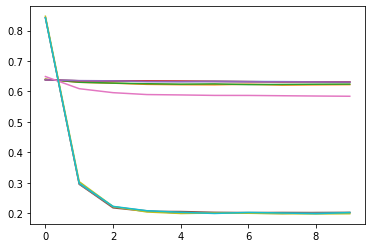

In [107]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(mis[0])
fig.show()

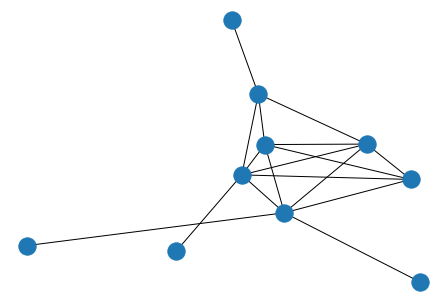

In [108]:
nx.draw(g)

In [ ]:
%load_ext autoreload
%autoreload 2
import multiprocessing as mp
from Toolbox import infcy
from itertools import product

n_samples = int(1e4)
repeats   = int(1e3)
params = dict(n_samples = \
              n_samples, \
              repeats = repeats)

models = [(Ising, g, params)]
combs = product(simTemps, models)

def runSim(props):
    print(props)
    t, mparams = props
    m, g, params = mparams
    m = m(graph = g, t = t[0], p_recomb = .4)
    sim = infcy.Simulator(m)
    snapshots = sim.snapshots(params.get('n_samples'), step = 1)
    sc = sim.forward(snapshots, params.get('repeats'), time_steps = 20)
    return sc

results = []
for r in combs:
    results.append(runSim(r))
# with mp.Pool(1) as p:

#     results = p.map(runSim, combs)

In [ ]:
# import dill, pickle
# with open('results.pickle', 'wb') as f:
#     pickle.dump(results, f)
# dill.dump_session('notebook_env.db')

In [ ]:
mis = []
for r in results:
    c = r.get('conditional')
    s = r.get('snapshots')
    _, mi = infcy.mutualInformation(c, s)
    mis.append(mi)

In [ ]:
lines = []

from plotly.subplots import make_subplots
# print(models[0][0])
fig = make_subplots(1, 3)
for idx, mi in enumerate(mis):
#     if True:
#     for node in range(g.number_of_nodes()):
#         hm = go.Scatter(y = mi[:, node], name = node)
#         fig.add_trace(hm, 1, idx + 1)
    hm = go.Heatmap( z = mi.T, zmin = 0, zmax = 1)
    fig.add_trace(hm, 1, idx + 1) 
fig.show()

In [ ]:
def f(x, a, b, c, d, e, f, g):
    return a * np.exp(-b * (x - c)) + d * np.exp(-e*(x - f)) + g

param = []

params = np.zeros((3, g.number_of_nodes(), 7))

r = np.zeros((3, g.number_of_nodes(), 2))
for idx, mi in enumerate(mis):
    for jdx, i in enumerate(mi.T):
        x = np.arange(len(i))
        opts, _ = optimize.curve_fit(f, xdata = x, ydata = i,\
                                       method = 'trf', bounds = (0, np.inf))
        
        mini = optimize.minimize(lambda x, c: \
                         abs(f(x, *c) - .5 * (c[0] + c[3]) - c[-1]),\
                         -1, \
                         method = 'TNC', \
                         args = opts, \
                         options = dict(maxiter = int(1e5)))
#         print(mini.message, mini)
        r[idx, jdx, 0] = mini.x
        r[idx, jdx, 1] = opts[-1]
        params[idx, jdx] = opts 

In [ ]:
estimates = np.zeros(params.reshape(-1, 6).shape[0])
from scipy import integrate

fig = make_subplots(rows = 1, cols = 3, \
                    shared_xaxes = True,\
                   x_title = "IDT",\
                   y_title = "AI")

for idx, i in enumerate(r):
    line = go.Scatter(x = i.T[0], y = i.T[1], mode = 'markers')
    fig.add_trace(line, col = idx + 1, row = 1)
    
fig.update_layout(\
                 )